In [1]:
import cv2 
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
from path import Path
import time

In [2]:
# Start the timer to record how long it takes for the script to be finished.
start_script = time.monotonic()

In [3]:
# Find the absolute paths to the folder with the training data and the text document with the true labels
imagedata = Path('imagedata').abspath()
labels_txt = Path('labels.txt').abspath()

# Create the new folder "segmentation" if it does not exist in the workspace
new_folder = 'segmentation'
try:
    os.mkdir(new_folder)
except:
    pass

segmentation = Path(new_folder).abspath()

In [4]:
# Fetch the images in "imagedata"
def number(i):
    if i < 10:
        return f'000{i}'
    elif i < 100: 
        return f'00{i}'
    elif i < 1000: 
        return f'0{i}'
    else:
        return f'{i}'


# Find the lowest x value for each contour and store the coordinates of each
# contour in an ascending order 
def sort(cnts):
    # Store the coordinates in a new array
    cnts_list = []
    cnts_sorted = []
    for i in range(len(cnts)):
        cnts_list.append(cnts[i][:,:,0].flatten())

    # Sort the new list ascendingly based on the lowest value for each bounding box 
    sorted_list = sorted(cnts_list, key=lambda x: min(x.flatten()))
    for j in range(len(cnts)):
        for k in range(len(cnts)):
            if len(sorted_list[j]) == len(cnts[k][:,:,0].flatten()):
                cnts_sorted.append(cnts[k])
                break
    return cnts_sorted

# Resize the images
def resize_func(width, height):
    dim = (width, height)
    return cv2.resize(roi, dim, interpolation = cv2.INTER_CUBIC)

# Visualize the contours of the last 10 training images
def visualize_contours(cnts_other):
    fig=plt.figure(figsize=(25, 10)) 
    for i in range(len(cnts_other)):
        x_coordinates = []
        y_coordinates = []
        for j in range(len(cnts_other[i])):
            x_coordinates.append(cnts_other[i][j][:,:,0].flatten())
            y_coordinates.append(cnts_other[i][j][:,:,1].flatten())
            plt.subplot(3,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.scatter(x_coordinates[j], 255- y_coordinates[j])
            plt.title(f'Image {nr_list[i]}')
    plt.show()


# Get the true labels from the text document and import these to an array where
# each element is an integer
def get_labels():
    with open(labels_txt) as f:
        labels_str = f.read().splitlines()

    true_labels= []
    for i in labels_str:
        numbers = i.replace(" ", "").split(",")
        for number in numbers:
            true_labels.append(int(number))
    return true_labels


# Calculate the accuracy of the classifier
def accuracy_score(true_labels, classifier):
    count = 0
    for i in range(len(true_labels)):
        if classifier[i] == true_labels[i]:
            count +=1
    accuracy = count/len(true_labels)
    return round(accuracy,3)
    

# Visualize the segmented images 
def visual_comparison(segmented_images, classifier, start, end):
    count = 0
    col = 5
    fig=plt.figure(figsize=(15, 15)) 
    rows = 5

    for img_nr in range(len(segmented_images[start:end])): 
        img = segmented_images[img_nr+start]
        fig.add_subplot(rows, col, 1+img_nr)
        plt.imshow(img, cmap = "gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Class {classifier[img_nr]}')  
    return plt.show()

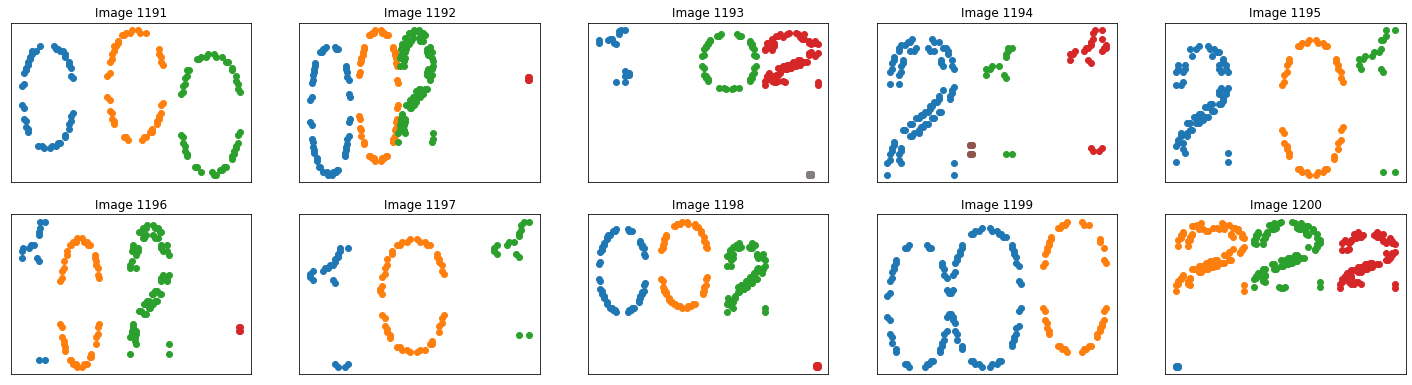

In [5]:
# The total number of images in "imagedata"
images = 1200 # Change this number when new images are introduced
j = 0
cnts_other, nr_list, segmented_images = [], [], []

# Segment each image in the training data
for i in range(1, images+1):
    
    # Fetch the image
    img = cv2.imread(imagedata + fr'\train_{number(i)}.png', 0)

    # Threshold the image: Use Otsu's method to maximize the variance between the classes and binarize the image 
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Construct the kernel size and apply the morphological operatior Opening on the image
    kernel = np.ones((2,2),np.uint8)
    erode = cv2.erode(thresh,kernel,iterations = 2)
    dilate = cv2.dilate(erode,kernel,iterations = 1) 

    # find contours in the image
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    # Sort the contours so that they will be saved from left to right in the new folder.
    cnts = sort(cnts)
    orig = img.copy()

    # Save the 10 last images
    if i >= 1191:
        cnts_other.append(cnts)
        nr_list.append(i)

    for cnt in cnts:
        # Ignore small contours
        if(cv2.contourArea(cnt) < 100):
            continue
        
        # Detect the coordinates of the bounding box
        x,y,w,h = cv2.boundingRect(cnt)

        # Take ROI of the cotour
        roi = dilate[y:y+h, x:x+w]
        
        # Standardize the height of the image
        height = 40 
        width = roi.shape[1]# Keep the original image width
        roi = resize_func(width, height)

        if 3000 > roi.shape[0]*roi.shape[1] > 1500:
            width = 60
            roi = resize_func(width, height) 

            left = roi[:,:len(roi[1])//2]
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), left)
            segmented_images.append(left)
            j += 1

            right =  roi[:,len(roi[1])//2:]
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), right)
            segmented_images.append(right)
            j += 1
            
        elif roi.shape[0]*roi.shape[1] > 3000:
            width = 90
            roi = resize_func(width, height) 

            left = roi[:,:len(roi[1])//3]
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), left)
            segmented_images.append(left)
            j += 1

            middle = roi[:,len(roi[1])//3:(2*len(roi[1]))//3]
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), middle)
            segmented_images.append(middle)
            j += 1

            right =  roi[:,2*len(roi[1])//3:(3*len(roi[1]))//3]
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), right)
            segmented_images.append(right)
            j += 1

        else:
            width = 30
            roi = resize_func(width, height) 
            # Save the image in the new folder
            cv2.imwrite(os.path.join(new_folder, "train" + str(j) + ".png"), roi)  # Comment this line if the images have                                                                                          been created
            segmented_images.append(roi)
            j += 1
# Just for fun, visualize all the coordinates of the contours of the last 10 training images
visualize_contours(cnts_other)

In [6]:
# Start the timer to record how long it takes for the classifier to be finished.
start_alg = time.monotonic()

In [7]:
# The total number of images in "segmented_images"
images = 3600 # Change this number when new images are introduced
count_NA=0
classifier = []

for img_nr in range(images):
    # Read the segmented images
    img = cv2.imread(segmentation+fr"\train{img_nr}.png", 0)

    # Find the bounding box for number one
    if img[29,0:10][0] == 0 and len(set(img[29,0:10])) == 1 or img[15:-3,-5][0] == 255 and len(set(img[15:-3,-5])) == 1 or img[20:-1,-6][0] == 0 and len(set(img[20:-1,-6])) == 1 or img[25:-1,-9][0] == 0 and len(set(img[25:-1,-9])) == 1:
        classifier.append(1)       

    # Find the bounding box for zero
    elif img[4:24,16][0] == 0 and len(set(img[4:24,16])) == 1 or img[22,9:21][0] == 0 and len(set(img[22,9:21])) == 1: 
        classifier.append(0)

    # Find the bounding box for number two
    elif img[-1,-10:-3][0] == 255 and len(set(img[-1,-10:-3])) == 1 or img[-5,-10:-3][0] == 255 and len(set(img[-5,-10:-3])) == 1 or img[-4,-10:-3][0] == 0 and len(set(img[-4,-10:-3])) == 1 or img[-3,-10:-3][0] == 255 and len(set(img[-3,-10:-3])) == 1 or img[-7,-10:-3][0] == 255 and len(set(img[-7,-10:-3])) == 1:
        classifier.append(2)

    # Non_classified numbers
    else:
        classifier.append("NA")
        count_NA+=1

 The accuracy of the classifier for the training data is: 0.997. 0 numbers were not classified (NA). 

 Elapsed time (classifer): 1.4 seconds, and 
 elapsed time (script):    6.0. 

 The first 20 numbers of the classifier:     [2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0], 
 the first 20 numbers of the actual numbers: [2, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0], and 
 a visualaztion of the 20 first numbers in "segmented_images" and their respective classification: 



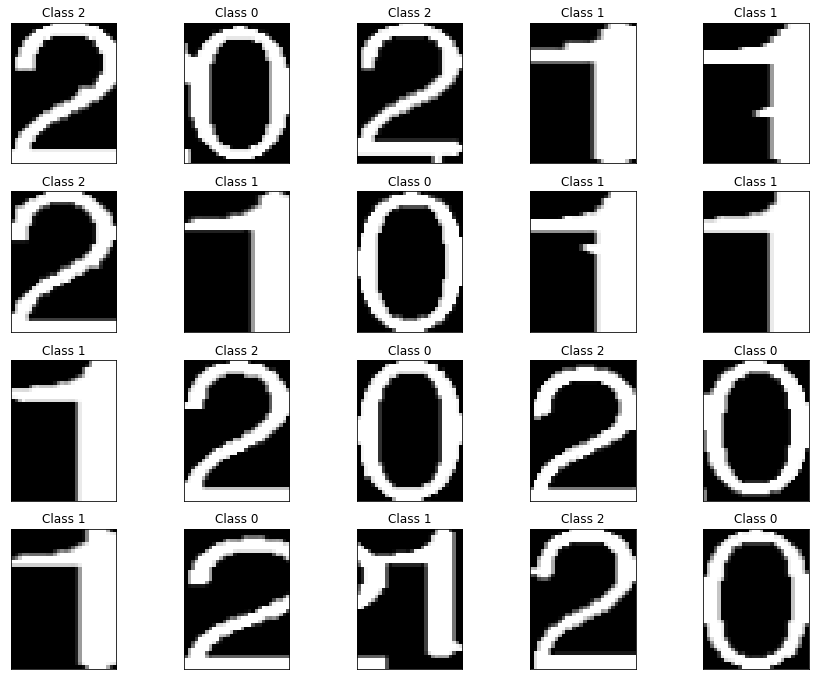

In [8]:
end_time = time.monotonic()

# Get the true labels in an array (where each element is an integer) and
# use the accuracy_score function to find the accuracy by using comparing 
# the true labels with the classifier
true_labels = get_labels()
accuracy = accuracy_score(true_labels, classifier)
start = 0
end = 20

print(f' The accuracy of the classifier for the training data is: {accuracy}. {count_NA} numbers were not classified (NA). \n\n Elapsed time (classifer): {round(timedelta(seconds=end_time - start_alg).total_seconds(),1)} seconds, and \n elapsed time (script):    {round(timedelta(seconds=end_time - start_script).total_seconds(),1)}. \n\n The first 20 numbers of the classifier:     {classifier[:20]}, \n the first 20 numbers of the actual numbers: {true_labels[:20]}, and \n a visualaztion of the 20 first numbers in "segmented_images" and their respective classification: \n')
visual_comparison(segmented_images, classifier, start, end)